<a href="https://colab.research.google.com/github/Kalaiselvan88/MLAssignments/blob/main/ML2Assignment1_Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setting the environment variables

In [ ]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number.

In [ ]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [ ]:
# initialising the session with 14 GB driver memory
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark

In [ ]:
# Spark session with 14 GB driver memory
spark.sparkContext.getConf().get('spark.driver.memory')

'14G'

In [ ]:
# loading the dataset from the EC2 instance - 2019-Oct.csv
df = spark.read.csv('inputdata/2019-Oct.csv', header = True, inferSchema = True)

In [ ]:
# exploring the dataframe - top 20 rows
df.show()

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:...|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:...|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:...|      view|  17200506|2053013559792632471|furniture.living_...|    null|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:...|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:...|      view|   1004237|205301355563188265

In [ ]:
# exploring the dataframe - schema
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [ ]:
# Number of rows and columns in the dataset
df.count()

42448764

So, we have a huge dataset that contains 42 million rows.

Now, tha dataset is loaded in Spark environment. Let's proceed with the desired tasks.

<hr>

## Task 1 - Data Exploration

**Find**
- 5 most popular:
    - Products sold by the e-commerce company in the month
    - Brands on the platform
    - Product categories
- Number of unique users and the most active user on the platform
- Average and maximum price for smartphones purchased by the customers
<br>

**Plot and comment**
- Event-type funnel distribution in e-commerce shopping journey
- Traffic on different days of the week

Provide the results in a separate report.

In [ ]:
# Let us first see what are the possible values for event_type column
df.groupBy('event_type').count().orderBy('count', ascending = 0).show()

+----------+--------+
|event_type|   count|
+----------+--------+
|      view|40779399|
|      cart|  926516|
|  purchase|  742849|
+----------+--------+



In [ ]:
# 5 most popular products sold
df.filter(df['event_type'] == 'purchase').groupBy("product_id").count().orderBy("count", ascending = False).show(5)

+----------+-----+
|product_id|count|
+----------+-----+
|   1004856|28944|
|   1004767|21806|
|   1004833|12697|
|   1005115|12543|
|   4804056|12381|
+----------+-----+
only showing top 5 rows



In [ ]:
# 5 most popular brands
df.groupBy("brand").count().orderBy("count", ascending = False).show(5)

+-------+-------+
|  brand|  count|
+-------+-------+
|   null|6113008|
|samsung|5282775|
|  apple|4122554|
| xiaomi|3083763|
| huawei|1111205|
+-------+-------+
only showing top 5 rows



In [ ]:
# Since above is showing null with high count let us increase count by 1
df.groupBy("brand").count().orderBy("count", ascending = False).show(6)

+-------+-------+
|  brand|  count|
+-------+-------+
|   null|6113008|
|samsung|5282775|
|  apple|4122554|
| xiaomi|3083763|
| huawei|1111205|
|lucente| 655861|
+-------+-------+
only showing top 6 rows



In [ ]:
# 5 most popular product categories
df.groupBy("category_code").count().orderBy("count", ascending = False).show(6, False)

+---------------------------+--------+
|category_code              |count   |
+---------------------------+--------+
|null                       |13515609|
|electronics.smartphone     |11507231|
|electronics.clocks         |1311033 |
|computers.notebook         |1137623 |
|electronics.video.tv       |1113750 |
|electronics.audio.headphone|1100188 |
+---------------------------+--------+
only showing top 6 rows



In [ ]:
# Number of unique users
df.select("user_id").distinct().count()

3022290

In [ ]:
# The most active user on the platform
df.groupBy("user_id").count().orderBy("count", ascending = False).show(1)

+---------+-----+
|  user_id|count|
+---------+-----+
|512475445| 7436|
+---------+-----+
only showing top 1 row



In [ ]:
# Average and Maximum price for smartphones purchased by the customers
# Below code gives the average price
df.filter("category_code == 'electronics.smartphone' AND event_type == 'purchase'").agg({"price": "avg"}).collect()

[Row(avg(price)=464.6191130945664)]

In [ ]:
# Below code gives the maximum price
df.filter("category_code == 'electronics.smartphone' AND event_type == 'purchase'").agg({"price": "max"}).collect()

[Row(max(price)=2110.45)]

In [ ]:
# Event-type funnel distribution
# Remember Spark dataframe cannot be visualised directly
# Install matplotlib
! pip3 install matplotlib 

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# Convert the spark to Pandas dataframe. Let us take just 1 column which is needed as data is huge.
pd_df_event_type = df.groupBy("event_type").count().orderBy("count", ascending = False).toPandas()

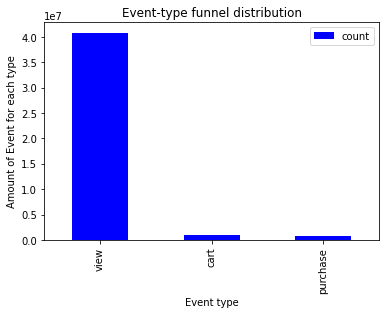

In [ ]:
import matplotlib.pyplot as plt
pd_df_event_type.plot(x = 'event_type', y = 'count', kind='bar', color = "blue")

plt.title('Event-type funnel distribution')
plt.ylabel('Amount of Event for each type')
plt.xlabel('Event type')
plt.show()

In [ ]:
# Traffic on different days of the week
# Remember Spark dataframe cannot be visualised directly

# Let us view the event_time column
df.select('event_time').show(20,False)

+-----------------------+
|event_time             |
+-----------------------+
|2019-10-01 00:00:00 UTC|
|2019-10-01 00:00:00 UTC|
|2019-10-01 00:00:01 UTC|
|2019-10-01 00:00:01 UTC|
|2019-10-01 00:00:04 UTC|
|2019-10-01 00:00:05 UTC|
|2019-10-01 00:00:08 UTC|
|2019-10-01 00:00:08 UTC|
|2019-10-01 00:00:10 UTC|
|2019-10-01 00:00:11 UTC|
|2019-10-01 00:00:11 UTC|
|2019-10-01 00:00:11 UTC|
|2019-10-01 00:00:13 UTC|
|2019-10-01 00:00:15 UTC|
|2019-10-01 00:00:16 UTC|
|2019-10-01 00:00:17 UTC|
|2019-10-01 00:00:18 UTC|
|2019-10-01 00:00:18 UTC|
|2019-10-01 00:00:19 UTC|
|2019-10-01 00:00:19 UTC|
+-----------------------+
only showing top 20 rows



In [ ]:
# Changing the type of column Date to timestamp
from pyspark.sql.functions import to_timestamp
df = df.withColumn("event_timestamp",to_timestamp('event_time',"yyyy-MM-dd H:m:s"))
df.select('event_timestamp').show(20, False)

+-------------------+
|event_timestamp    |
+-------------------+
|2019-10-01 00:00:00|
|2019-10-01 00:00:00|
|2019-10-01 00:00:01|
|2019-10-01 00:00:01|
|2019-10-01 00:00:04|
|2019-10-01 00:00:05|
|2019-10-01 00:00:08|
|2019-10-01 00:00:08|
|2019-10-01 00:00:10|
|2019-10-01 00:00:11|
|2019-10-01 00:00:11|
|2019-10-01 00:00:11|
|2019-10-01 00:00:13|
|2019-10-01 00:00:15|
|2019-10-01 00:00:16|
|2019-10-01 00:00:17|
|2019-10-01 00:00:18|
|2019-10-01 00:00:18|
|2019-10-01 00:00:19|
|2019-10-01 00:00:19|
+-------------------+
only showing top 20 rows



In [ ]:
### Extract day of week and hour from date in pyspark
from pyspark.sql.functions import dayofweek, hour

# create a new column for dayofweek from event_time
df = df.withColumn('day_of_week', dayofweek(df["event_timestamp"]))
df = df.withColumn('hour', hour(df["event_timestamp"]))
df.select('day_of_week','hour').show(20, False)

+-----------+----+
|day_of_week|hour|
+-----------+----+
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
|3          |0   |
+-----------+----+
only showing top 20 rows



In [ ]:
# Check schema
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)



In [ ]:
# Convert the spark to Pandas dataframe. Let us take just 1 column which is needed as data is huge.
pd_df_day_week = df.groupBy("day_of_week").count().orderBy("day_of_week").toPandas()

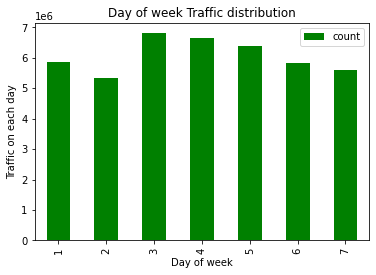

In [ ]:
pd_df_day_week.plot(x = 'day_of_week', y = 'count', kind='bar', color = "green")

plt.title('Day of week Traffic distribution')
plt.ylabel('Traffic on each day')
plt.xlabel('Day of week')
plt.show()

In [ ]:
# drop redundant column(s), if any
# Let us drop the event_time and event_timestamp columns as we have day_of_week and hour columns now
df = df.drop('event_time','event_timestamp')
df.printSchema()

root
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)



<hr>

## Task 2 - Feature Engineering

- Handle missing values (provide justification for approach)
- Generate the category code at 2 levels (Split into 2 columns)
    - Example: electronics.video.tv - electronics, video
- Capture user activity in different columns
    - Total activities (view/cart/etc.) in the session
    - Affinity towards a particular product (Product count for user)
    - Affinity towards a category (Secondary category count for user)
    - Average shopping expense for a product category (secondary)
    - Number of user sessions
- Impact of time: Day and Hour (Binning hours into 4 buckets)
- Reduction in brands for analysis: Top 20 + ‘others’
- Target variable generation: is_purchased


In [ ]:
# Handling missing values
from pyspark.sql.functions import *
# Let us check for nan values
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).show()

+----------+----------+-----------+-------------+-----+-----+-------+------------+-----------+----+
|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|day_of_week|hour|
+----------+----------+-----------+-------------+-----+-----+-------+------------+-----------+----+
|         0|         0|          0|            0|    0|    0|      0|           0|          0|   0|
+----------+----------+-----------+-------------+-----+-----+-------+------------+-----------+----+



In [ ]:
# Let us also check for Null values
df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).show()

+----------+----------+-----------+-------------+-------+-----+-------+------------+-----------+----+
|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|day_of_week|hour|
+----------+----------+-----------+-------------+-------+-----+-------+------------+-----------+----+
|         0|         0|          0|     13515609|6113008|    0|      0|           2|          0|   0|
+----------+----------+-----------+-------------+-------+-----+-------+------------+-----------+----+



In [ ]:
# Let us have a look at what percentage of data is brand null
df.filter(df['brand'].isNull()).count()/df.count()

0.14400909293848932

In [ ]:
# Let us have a look at what percentage of data is category_code null
df.filter(df['category_code'].isNull()).count()/df.count()

0.3183981752684248

#### Reason for the action performed:
Since there are a lot of rows with null values and we still need those rows to track other activities of user, let us impute the null rows with 'NA' value since the columns which has Null values are string

In [ ]:
# Imputing the Null values
df = df.na.fill('NA')
df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).show()

+----------+----------+-----------+-------------+-----+-----+-------+------------+-----------+----+
|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|day_of_week|hour|
+----------+----------+-----------+-------------+-----+-----+-------+------------+-----------+----+
|         0|         0|          0|            0|    0|    0|      0|           0|          0|   0|
+----------+----------+-----------+-------------+-----+-----+-------+------------+-----------+----+



In [ ]:
# Check for total row count
df.count()

42448764

The count is same and we have not lost anything

In [ ]:
# Checking for duplicate entries
df_distinct = df.distinct()
duplicates = df.count() - df_distinct.count()
duplicates

12765846

In [ ]:
# Take required action here
df = df.dropDuplicates()

In [ ]:
# drop redundant column(s), if any
df.printSchema()

root
 |-- event_type: string (nullable = false)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = false)
 |-- brand: string (nullable = false)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = false)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)



There are no redundant columns

In [ ]:
# Generating 2 columns from category code
# Columns have only single entity (electronics.video.tv: electronics, video)
# Check if split command works with '.' or Spark treats it as special character
import pyspark.sql.functions as F
split_col = F.split(df['category_code'], '\.')
df = df.withColumn('cat_l1', split_col.getItem(0))
df = df.withColumn('cat_l2', split_col.getItem(1))

In [ ]:
# Check if the column is added
df.select('category_code','cat_l1','cat_l2').show()

+--------------------+-----------+-----------+
|       category_code|     cat_l1|     cat_l2|
+--------------------+-----------+-----------+
|       apparel.shoes|    apparel|      shoes|
|                  NA|         NA|       null|
|electronics.smart...|electronics| smartphone|
|                  NA|         NA|       null|
|                  NA|         NA|       null|
|appliances.person...| appliances|   personal|
|       apparel.shoes|    apparel|      shoes|
|appliances.kitche...| appliances|    kitchen|
|  electronics.clocks|electronics|     clocks|
|electronics.smart...|electronics| smartphone|
|computers.periphe...|  computers|peripherals|
|  accessories.wallet|accessories|     wallet|
|       kids.carriage|       kids|   carriage|
|electronics.smart...|electronics| smartphone|
|auto.accessories....|       auto|accessories|
|  apparel.shoes.keds|    apparel|      shoes|
|                  NA|         NA|       null|
|                  NA|         NA|       null|
|            

In [ ]:
# Fill Null values for new category columns
df = df.na.fill('NA')
df.select('category_code','cat_l1','cat_l2').show()

+--------------------+-----------+-----------+
|       category_code|     cat_l1|     cat_l2|
+--------------------+-----------+-----------+
|       apparel.shoes|    apparel|      shoes|
|                  NA|         NA|         NA|
|electronics.smart...|electronics| smartphone|
|                  NA|         NA|         NA|
|                  NA|         NA|         NA|
|appliances.person...| appliances|   personal|
|       apparel.shoes|    apparel|      shoes|
|appliances.kitche...| appliances|    kitchen|
|  electronics.clocks|electronics|     clocks|
|electronics.smart...|electronics| smartphone|
|computers.periphe...|  computers|peripherals|
|  accessories.wallet|accessories|     wallet|
|       kids.carriage|       kids|   carriage|
|electronics.smart...|electronics| smartphone|
|auto.accessories....|       auto|accessories|
|  apparel.shoes.keds|    apparel|      shoes|
|                  NA|         NA|         NA|
|                  NA|         NA|         NA|
|            

In [ ]:
# Activities in a session by the user
# Window functions can be helpful here
from pyspark.sql import Window
session_window = Window.partitionBy("user_session")
df.withColumn("activity_count", F.count("event_type").over(session_window)).select('user_id','user_session','activity_count').dropDuplicates().show(30, False)

+---------+------------------------------------+--------------+
|user_id  |user_session                        |activity_count|
+---------+------------------------------------+--------------+
|564555327|00019495-9f33-48fa-ae79-c94c951aba40|1             |
|543073137|0002854a-13ef-490a-a838-b3be082eedd4|17            |
|513193974|0002a642-8f4a-48cb-89b6-260cc37073e8|1             |
|513257116|0002af2d-cbff-4557-b6fd-ee00a86de4c1|1             |
|553177004|00084f25-74e3-4df7-be8c-5504588f1f45|1             |
|519287061|00088378-6d3f-40cf-ad96-6e3a5aa24d6b|1             |
|554129220|000a2754-1167-47ce-88c7-92fa7eae9d6d|7             |
|513649894|000a378f-37b9-4f8c-b315-679003e41053|9             |
|547170917|000b2a8a-194b-40be-b4ba-e3f01b6a895c|6             |
|393914239|000d8e70-ed4a-4d51-b7a9-035168d79efd|1             |
|555374095|000d99dc-b6e9-4305-938e-3a4bc45a2052|5             |
|555623672|000e9abc-3a8b-4bc8-9139-2cf954973750|6             |
|523101797|000eef2b-65e5-4eaa-8768-f1689

In [ ]:
# View count for a product by the user
# Window functions can be helpful here
user_window = Window.partitionBy("product_id").partitionBy("user_id")
df_view_count = df.filter("event_type == 'view'")
df_view_count.withColumn("view_count", F.count("event_type").over(user_window)).select('user_id','product_id','view_count').dropDuplicates().show(60, False)

+---------+----------+----------+
|user_id  |product_id|view_count|
+---------+----------+----------+
|240522111|5100565   |27        |
|240522111|4804056   |27        |
|240522111|5100566   |27        |
|240522111|5100854   |27        |
|240522111|4804055   |27        |
|240522111|4802036   |27        |
|240522111|18500054  |27        |
|240522111|5100567   |27        |
|240522111|4803976   |27        |
|277067319|3701151   |5         |
|277067319|3700412   |5         |
|277067319|17200971  |5         |
|277067319|3701429   |5         |
|277067319|3701101   |5         |
|303418896|13900421  |5         |
|303418896|36600080  |5         |
|303418896|36600091  |5         |
|303418896|36600096  |5         |
|303418896|36600028  |5         |
|356463487|1003315   |3         |
|356463487|1004238   |3         |
|357446328|2600940   |18        |
|357446328|2600574   |18        |
|357446328|2600652   |18        |
|357446328|2601430   |18        |
|357446328|2601340   |18        |
|357446328|260

In [ ]:
# View count for the secondary category by the user
# Window functions can be helpful here
user_window = Window.partitionBy("cat_l2").partitionBy("user_id")
df_view_cat_filter = df.filter("event_type == 'view'").filter("cat_l2 != 'NA'")
df_view_cat_filter.withColumn("view_count", F.count("event_type").over(user_window)).select('user_id','cat_l2','view_count').dropDuplicates().show(30, False)

+---------+--------------+----------+
|user_id  |cat_l2        |view_count|
+---------+--------------+----------+
|240522111|clocks        |27        |
|240522111|audio         |27        |
|240522111|tablet        |27        |
|277067319|environment   |5         |
|277067319|living_room   |5         |
|303418896|components    |1         |
|356463487|smartphone    |3         |
|366968564|clocks        |6         |
|366968564|carriage      |6         |
|389518481|environment   |4         |
|391260478|fmcg          |1         |
|406827257|smartphone    |1         |
|410271694|smartphone    |2         |
|420155938|smartphone    |1         |
|420412138|smartphone    |3         |
|424456347|smartphone    |1         |
|425909320|smartphone    |1         |
|429549742|smartphone    |4         |
|439042093|sewing_machine|1         |
|445162060|tablet        |23        |
|445162060|environment   |23        |
|445162060|kitchen       |23        |
|445162060|iron          |23        |
|447882609|s

In [ ]:
# Average shopping expense for a product category
# Window functions can be helpful here
cat_window = Window.partitionBy("cat_l2")
df_shop_cat_filter = df.filter("event_type == 'purchase'").filter("cat_l2 != 'NA'")
df_shop_cat_filter.withColumn("avg_price", F.avg("price").over(cat_window)).select('cat_l2','avg_price').dropDuplicates().show(30, False)

+-----------+------------------+
|cat_l2     |avg_price         |
+-----------+------------------+
|clocks     |267.6873304091836 |
|desktop    |346.98866493842996|
|peripherals|149.08874292643486|
|shoes      |79.2413671817497  |
|shirt      |51.64783783783781 |
|smartphone |464.1542272617024 |
|jumper     |30.63             |
|bedroom    |154.22857561793043|
|fmcg       |13.71985155195684 |
|trainer    |302.36889830508477|
|wallet     |48.96971530249106 |
|shorts     |16.09             |
|cartrige   |15.267538461538452|
|ski        |244.89875         |
|umbrella   |25.480000000000008|
|tablet     |277.41042915136035|
|lawn_mower |148.05837209302322|
|skates     |286.8628310502271 |
|kitchen    |212.4026546304877 |
|dress      |58.087333333333326|
|jeans      |44.02307142857143 |
|iron       |61.28573277074591 |
|belt       |58.209523809523816|
|living_room|299.32971859588224|
|audio      |115.86345935268335|
|bathroom   |83.90974358974363 |
|ebooks     |162.4964184397166 |
|underwear

In [ ]:
# Session count for a user
# Window functions can be helpful here
user_window = Window.partitionBy("user_id")
df.withColumn("session_count", F.count("user_session").over(user_window)).select('user_id','session_count').dropDuplicates().show(30, False)

+---------+-------------+
|user_id  |session_count|
+---------+-------------+
|240522111|27           |
|277067319|5            |
|303418896|5            |
|356463487|3            |
|357446328|18           |
|366968564|6            |
|369454898|1            |
|370633539|1            |
|389518481|5            |
|391260478|7            |
|406827257|1            |
|410271694|2            |
|420155938|1            |
|420412138|3            |
|424456347|1            |
|425909320|2            |
|429549742|4            |
|438192512|3            |
|439042093|1            |
|445162060|50           |
|446123093|1            |
|446135485|3            |
|447882609|2            |
|448241309|8            |
|448790742|1            |
|450641019|1            |
|453573642|4            |
|454388908|3            |
|455624703|14           |
|456119138|2            |
+---------+-------------+
only showing top 30 rows



In [ ]:
# Generating the hour variable
# We have already generated the hour variable above
df.show(10, False)

+----------+----------+-------------------+-------------------------------+-------+------+---------+------------------------------------+-----------+----+-----------+----------+
|event_type|product_id|category_id        |category_code                  |brand  |price |user_id  |user_session                        |day_of_week|hour|cat_l1     |cat_l2    |
+----------+----------+-------------------+-------------------------------+-------+------+---------+------------------------------------+-----------+----+-----------+----------+
|view      |28718142  |2053013565782098913|apparel.shoes                  |fassen |51.22 |518471395|52053f12-5030-4484-82fb-d20dc4062a27|3          |0   |apparel    |shoes     |
|view      |10800048  |2053013554994348409|NA                             |redmond|66.29 |539194858|5fe9d0a0-0de6-47de-a55a-eae9f89475cd|3          |0   |NA         |NA        |
|view      |1004659   |2053013555631882655|electronics.smartphone         |samsung|787.18|514218020|d7c4761f-d

In [ ]:
# Impact of time: Day and Hour (Binning hours into 4 buckets)
from pyspark.ml.feature import Bucketizer
# Here we are splitting into 4 as midnight and early morning, morning, noon, evening and night
bucketizer = Bucketizer(splits=[0,8,12,16,23],inputCol="hour", outputCol="hour_bucket")
df = bucketizer.setHandleInvalid("keep").transform(df)
df.select('hour','hour_bucket').show()

+----+-----------+
|hour|hour_bucket|
+----+-----------+
|   0|        0.0|
|   0|        0.0|
|   0|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
|   2|        0.0|
+----+-----------+
only showing top 20 rows



In [ ]:
# Reduction in brands for analysis: Top 20 + ‘others'
# Let us first get top 20 brands based on different events. Hence the row count should help here.
df.groupBy('brand').count().orderBy('count', ascending = 0).show(21, False)

+--------+-------+
|brand   |count  |
+--------+-------+
|NA      |4542823|
|samsung |3580281|
|apple   |3058048|
|xiaomi  |1940090|
|huawei  |736368 |
|lucente |498799 |
|bosch   |364026 |
|lg      |360396 |
|oppo    |327184 |
|sony    |307580 |
|acer    |275298 |
|cordiant|255957 |
|respect |225769 |
|lenovo  |220647 |
|artel   |206830 |
|hp      |199882 |
|indesit |193595 |
|casio   |187350 |
|dauscher|186141 |
|philips |183704 |
|stels   |182506 |
+--------+-------+
only showing top 21 rows



In [ ]:
top_brands = ['samsung','apple','xiaomi','huawei','lucente','bosch','lg','oppo','sony','acer','cordiant','respect',
             'lenovo',
             'artel',
             'hp',
             'indesit',
             'casio',
             'dauscher',
             'philips',
             'stels']

df = df.withColumn('brand_red', when(col('brand').isin(top_brands), col('brand')).otherwise('others'))
df.select('brand','brand_red').show()

+---------+---------+
|    brand|brand_red|
+---------+---------+
|   fassen|   others|
|  redmond|   others|
|  samsung|  samsung|
|      bts|   others|
|  matador|   others|
|  philips|  philips|
|       NA|   others|
|     beko|   others|
|   orient|   others|
|    apple|    apple|
|       lg|       lg|
|    karya|   others|
|wingoffly|   others|
|    apple|    apple|
|   alpine|   others|
|    escan|   others|
| nestogen|   others|
|    lider|   others|
|  navitel|   others|
|legeartis|   others|
+---------+---------+
only showing top 20 rows



In [ ]:
# Generating 'is_purchased' variable
df = df.withColumn('is_purchased', when(col('event_type') == 'purchase', 1).otherwise(0))
df.select('event_type','is_purchased').show()

+----------+------------+
|event_type|is_purchased|
+----------+------------+
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
|      view|           0|
+----------+------------+
only showing top 20 rows



In [ ]:
# Dropping the redundant columns 
df = df.drop('event_type','category_code','brand','hour')

In [ ]:
# Printing the top 20 rows as output
df.show()

+----------+-------------------+------+---------+--------------------+-----------+-----------+-----------+-----------+---------+------------+
|product_id|        category_id| price|  user_id|        user_session|day_of_week|     cat_l1|     cat_l2|hour_bucket|brand_red|is_purchased|
+----------+-------------------+------+---------+--------------------+-----------+-----------+-----------+-----------+---------+------------+
|  28718142|2053013565782098913| 51.22|518471395|52053f12-5030-448...|          3|    apparel|      shoes|        0.0|   others|           0|
|  10800048|2053013554994348409| 66.29|539194858|5fe9d0a0-0de6-47d...|          3|         NA|         NA|        0.0|   others|           0|
|   1004659|2053013555631882655|787.18|514218020|d7c4761f-de75-454...|          3|electronics| smartphone|        0.0|  samsung|           0|
|  13400622|2053013557066334713| 61.75|515225374|f05a6d28-f388-4bb...|          3|         NA|         NA|        0.0|   others|           0|
|  127

In [ ]:
# Dropping redundant rows
df = df.dropDuplicates()

In [ ]:
# Columns in df after feature engineering
df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = false)
 |-- day_of_week: integer (nullable = true)
 |-- cat_l1: string (nullable = false)
 |-- cat_l2: string (nullable = false)
 |-- hour_bucket: double (nullable = true)
 |-- brand_red: string (nullable = false)
 |-- is_purchased: integer (nullable = false)



In [ ]:
# Storing the cleaned df in the instance to prevent repetition of steps again
# Rename the file based on your preferences
df.coalesce(1).write.option("header", "true").parquet("cleaned_df.parquet")

Proceed to another notebooks after saving the dataframe.